In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

# Need to move TRANSFORMERS and text_to_code_q6 to other script
from build_model_multinomial import TRANSFORMERS, text_to_code_q6, text_to_code_q10_2_binary, fallback_text_to_float
from build_model_logistic import build_v2g_model_binary_from_df, run_single_feature_regressions, filter_significant_features
from get_data import init_column_map, pull_data_rowwise
from logistic_results_plot import (
    plot_feature_significance, 
    plot_coefficients_barh_by_abscoef, 
    plot_odds_ratio_barh, 
    plot_p_value_barh, 
    plot_log_p_value_barh, 
    plot_coefficients_significance_barh, 
    plot_coefficient_vs_significance,
    plot_coefficients_barplot,
    plot_odds_ratios_barplot,
    plot_coefficients_by_abs,
    plot_binary_confusion_matrix,
    transform_and_plot_correlation
)

from segmentation import filter_data

In [2]:
# Define all variable categories
from variables import (
    demographics, 
    input_variables_vehicle_ownership, 
    familiarity, 
    kms_driven, 
    renewables_at_home,
    parking, 
    q6a_cols, 
    energ_literacy, 
    renewables_at_home, 
    intent_to_purchase_vehicle,
    benefits_v2g, 
    concerns_v2g, 
    interest_in_services, 
    consider_using_NRMA_for,
    charging_control, 
    preference_on_batt_use, 
    expected_return,
    q6a_petrol, q6a_ev, q6a_plughyb, q6a_hybrid,
#     charging_control,
    feature_label_map
)

# 2. Model Setup

## 2.1. Initialise dataframe

In [3]:
csv_file = './data/survey_pre_processed_data.csv'

In [4]:
target_variable = 'Q10_2'  # "I would be interested in installing V2G..."

In [5]:
q10_2_categories = [
    "Strongly disagree",
    "Somewhat disagree",
    "Neither agree nor disagree",
    "Somewhat agree",
    "Strongly agree"
    ]

In [10]:
# Pull the data from CSV
init_column_map(csv_file)

# TBD -> Make function here
columns_of_interest = (
    familiarity +
    kms_driven + 
    renewables_at_home + 
    q6a_cols + 
    demographics + 
    input_variables_vehicle_ownership + 
    intent_to_purchase_vehicle +
    parking + 
    benefits_v2g + 
    concerns_v2g +
    energ_literacy +
#   charging_control +
    [target_variable]
    )

rows = pull_data_rowwise(columns_of_interest, csv_file)

# Make a DataFrame
df = pd.DataFrame(rows, columns=columns_of_interest)
df

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax1_2,Q6ax1_3,Q6ax2_1,Q6ax2_2,...,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
0,Somewhat familiar,"Less than 10,000",1,0,0,3,5,5,,,...,1,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
1,Very familiar,"Less than 10,000",1,1,0,5,5,5,5,5,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
2,Not at all familiar,"20,001-50,000",0,0,1,2,1,2,,,...,0,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Strongly disagree
3,Not at all familiar,"Less than 10,000",0,0,1,,,,,,...,0,0,0,0,0,0,Somewhat disagree,Somewhat disagree,Somewhat agree,Somewhat disagree
4,Very familiar,"20,001-50,000",1,1,0,5,5,5,4,4,...,0,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Somewhat agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Somewhat familiar,"10,000-20,000",1,1,0,,,,1,3,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree
1354,Somewhat familiar,"Less than 10,000",0,0,1,5,5,5,,,...,0,0,1,0,1,0,Strongly agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
1355,Very familiar,"10,000-20,000",1,0,0,4,4,5,4,4,...,0,1,0,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Strongly agree
1356,Very familiar,"10,000-20,000",0,0,1,,,,3,5,...,0,0,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree


## 2.2. Segment

In [11]:
'''
Here's the only thing different from previous notebook.
We'll consider a segmentation based on a question (or combination of)

e.g.:
segment_1_filters = ["Q1_2 == '1'", "(Q3_1 == '1') | (Q3_2 == '1')"]
or
filters = ["Q1_2 == '1'"]

'''

'\nHere\'s the only thing different from previous notebook.\nWe\'ll consider a segmentation based on a question (or combination of)\n\ne.g.:\nsegment_1_filters = ["Q1_2 == \'1\'", "(Q3_1 == \'1\') | (Q3_2 == \'1\')"]\nor\nfilters = ["Q1_2 == \'1\'"]\n\n'

In [12]:
# Change string to numeric
df[input_variables_vehicle_ownership] = df[input_variables_vehicle_ownership].apply(pd.to_numeric, errors='coerce')
df[intent_to_purchase_vehicle] = df[intent_to_purchase_vehicle].apply(pd.to_numeric, errors='coerce')
df[parking] = df[parking].apply(pd.to_numeric, errors='coerce')

In [13]:
ev_owners = ["Q1_2 == 1"]
df_segment_1 = filter_data(df, ev_owners)

In [14]:
# NOT EV owners who want to buy EV in the next 5 years
buying_ev_5_years = ["(Q1_2 != 1) & (Q5_2 == 1)"]
df_segment_2 = filter_data(df, buying_ev_5_years)

In [15]:
'''# Segment 1: EV owners
filters_segment_1 = ["Q1_2 == '1'"]
df_segment_1 = filter_data(df, filters_segment_1)

# Segment 2: EV owners with off-street parking
filters_segment_2 = ["Q1_2 != '1'", "Q3_1 == '1'"]  # Adjust filter conditions
df_segment_2 = filter_data(df, filters_segment_2)'''

'# Segment 1: EV owners\nfilters_segment_1 = ["Q1_2 == \'1\'"]\ndf_segment_1 = filter_data(df, filters_segment_1)\n\n# Segment 2: EV owners with off-street parking\nfilters_segment_2 = ["Q1_2 != \'1\'", "Q3_1 == \'1\'"]  # Adjust filter conditions\ndf_segment_2 = filter_data(df, filters_segment_2)'

In [16]:
df_segment_1

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax1_2,Q6ax1_3,Q6ax2_1,Q6ax2_2,...,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
1,Very familiar,"Less than 10,000",1,1,0,5,5,5,5,5,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
4,Very familiar,"20,001-50,000",1,1,0,5,5,5,4,4,...,0,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Somewhat agree
5,Very familiar,"20,001-50,000",1,0,0,5,5,5,5,5,...,0,0,1,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
9,Very familiar,"20,001-50,000",0,0,1,3,5,5,3,5,...,0,0,1,0,0,0,Neither agree nor disagree,Somewhat agree,Somewhat agree,Strongly agree
10,Somewhat familiar,"10,000-20,000",1,0,0,2,2,5,1,3,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Neither agree nor disagree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,Very familiar,"10,000-20,000",1,0,0,,,,2,3,...,0,1,0,0,1,0,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
1353,Somewhat familiar,"10,000-20,000",1,1,0,,,,1,3,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree
1355,Very familiar,"10,000-20,000",1,0,0,4,4,5,4,4,...,0,1,0,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Strongly agree
1356,Very familiar,"10,000-20,000",0,0,1,,,,3,5,...,0,0,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree


In [17]:
df_segment_2

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax1_2,Q6ax1_3,Q6ax2_1,Q6ax2_2,...,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
0,Somewhat familiar,"Less than 10,000",1,0,0,3,5,5,,,...,1,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
14,Not at all familiar,"Less than 10,000",1,0,0,2,5,5,,,...,0,0,0,1,0,0,Neither agree nor disagree,Somewhat disagree,Somewhat disagree,Neither agree nor disagree
22,Very familiar,"20,001-50,000",1,0,0,5,5,5,,,...,0,0,1,0,1,0,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
29,Not at all familiar,"10,000-20,000",0,0,1,3,5,5,,,...,0,0,0,0,0,1,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree
31,Somewhat familiar,"10,000-20,000",1,1,0,3,5,5,,,...,0,0,1,1,0,0,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,Somewhat familiar,"20,001-50,000",1,1,0,2,5,5,,,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
1208,Not at all familiar,"20,001-50,000",0,0,1,4,3,5,,,...,1,0,1,0,0,0,Neither agree nor disagree,Somewhat disagree,Somewhat agree,Neither agree nor disagree
1231,Very familiar,"Less than 10,000",0,0,1,1,2,2,,,...,0,0,0,0,0,0,Strongly agree,Strongly agree,Strongly agree,Strongly agree
1296,Somewhat familiar,"10,000-20,000",1,0,0,4,5,5,,,...,0,0,0,1,1,0,Somewhat agree,Strongly agree,Somewhat disagree,Neither agree nor disagree


## 2.2. Clean data

In [18]:
# Ensure "0 - Weekdays" is converted correctly
for col in q6a_cols:
    df_segment_1[col] = df_segment_1[col].replace("0 - Weekdays", 0)  # Convert "0 - Weekdays" to 0
    df_segment_1[col] = pd.to_numeric(df_segment_1[col], errors='coerce')  # Convert all values to numbers

# Debugging: Check unique values in each column
for col in q6a_cols:
    print(f"Unique values in {col}: {df_segment_1[col].dropna().unique()}")

Unique values in Q6ax1_1: [5. 3. 2. 0. 4. 1.]
Unique values in Q6ax1_2: [5. 2. 4. 3. 0. 1.]
Unique values in Q6ax1_3: [5. 4. 0. 3. 2. 1.]
Unique values in Q6ax2_1: [5 4 3 1 2 0]
Unique values in Q6ax2_2: [5 4 3 2 0 1]
Unique values in Q6ax2_3: [5 4 3 1 0 2]
Unique values in Q6ax3_1: [3. 1. 2. 4. 5.]
Unique values in Q6ax3_2: [5. 2.]
Unique values in Q6ax3_3: [5. 2.]
Unique values in Q6ax4_1: [2. 0. 5. 3. 4. 1.]
Unique values in Q6ax4_2: [2. 0. 4. 5. 3. 1.]
Unique values in Q6ax4_3: [5. 0. 4. 1.]


C:\Users\24417507\AppData\Local\Temp\ipykernel_8260\3436650756.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment_1[col] = df_segment_1[col].replace("0 - Weekdays", 0)  # Convert "0 - Weekdays" to 0
C:\Users\24417507\AppData\Local\Temp\ipykernel_8260\3436650756.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment_1[col] = pd.to_numeric(df_segment_1[col], errors='coerce')  # Convert all values to numbers


In [19]:
# Ensure "0 - Weekdays" is converted correctly
for col in q6a_cols:
    df_segment_2[col] = df_segment_2[col].replace("0 - Weekdays", 0)  # Convert "0 - Weekdays" to 0
    df_segment_2[col] = pd.to_numeric(df_segment_2[col], errors='coerce')  # Convert all values to numbers

# Debugging: Check unique values in each column
for col in q6a_cols:
    print(f"Unique values in {col}: {df_segment_2[col].dropna().unique()}")

Unique values in Q6ax1_1: [3. 2. 5. 4. 1. 0.]
Unique values in Q6ax1_2: [5. 4. 3. 1. 2.]
Unique values in Q6ax1_3: [5. 4. 3. 0. 1. 2.]
Unique values in Q6ax2_1: []
Unique values in Q6ax2_2: []
Unique values in Q6ax2_3: []
Unique values in Q6ax3_1: [3. 4. 0. 5. 2. 1.]
Unique values in Q6ax3_2: [5. 4. 3.]
Unique values in Q6ax3_3: [5. 2. 4.]
Unique values in Q6ax4_1: [5. 0. 2. 4. 3.]
Unique values in Q6ax4_2: [3. 5. 0. 1.]
Unique values in Q6ax4_3: [3. 5. 1. 0.]


C:\Users\24417507\AppData\Local\Temp\ipykernel_8260\2659260973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment_2[col] = df_segment_2[col].replace("0 - Weekdays", 0)  # Convert "0 - Weekdays" to 0
C:\Users\24417507\AppData\Local\Temp\ipykernel_8260\2659260973.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment_2[col] = pd.to_numeric(df_segment_2[col], errors='coerce')  # Convert all values to numbers


In [20]:
# Count missing responses for each charging question
missing_counts = (df_segment_1[q6a_cols] == 0).sum()
# Display summary of non-responses per column
print("Number of responses recorded as 0:")
print(missing_counts)

Number of responses recorded as 0:
Q6ax1_1     41
Q6ax1_2      8
Q6ax1_3     10
Q6ax2_1    102
Q6ax2_2     24
Q6ax2_3     14
Q6ax3_1      0
Q6ax3_2      0
Q6ax3_3      0
Q6ax4_1      5
Q6ax4_2      2
Q6ax4_3      2
dtype: int64


In [21]:
# Checking number of vehicles per type
print(df_segment_1[q6a_petrol + q6a_ev + q6a_plughyb + q6a_hybrid].notna().sum())

Q6ax1_1    342
Q6ax1_2    342
Q6ax1_3    342
Q6ax2_1    768
Q6ax2_2    768
Q6ax2_3    768
Q6ax3_1      9
Q6ax3_2      9
Q6ax3_3      9
Q6ax4_1     35
Q6ax4_2     35
Q6ax4_3     35
dtype: int64


## 2.3. Update transformers to consider Q10_2 as binary (other than multinomial)

In [22]:
# Make a copy of TRANSFORMERS and update it with Q6a mappings
TRANSFORMERS_q6a = TRANSFORMERS.copy()

In [23]:
# Update with Q6a_* variables (charging behavior questions)
TRANSFORMERS_q6a.update({
    **{q: text_to_code_q6 for q in q6a_petrol},  
    **{q: text_to_code_q6 for q in q6a_ev},      
    **{q: text_to_code_q6 for q in q6a_plughyb}, 
    **{q: text_to_code_q6 for q in q6a_hybrid}   
})

In [24]:
TRANSFORMERS_q6a[target_variable] = text_to_code_q10_2_binary
TRANSFORMERS_q6a

{'Q1_1': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_2': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_3': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_4': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_99': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q2': <function build_model_multinomial.text_to_code_q2(raw_ans)>,
 'Q3_1': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_2': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_3': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_4': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_5': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q7_1': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_2': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_3': <functio

# 3. Feature Selection - Univariate Logistic Regression Analysis

## 3.1. Full dataset

In [25]:
features_to_select = (
    familiarity + 
    kms_driven +
    renewables_at_home +
    input_variables_vehicle_ownership + 
    q6a_petrol + 
    q6a_ev + 
    q6a_hybrid +
    q6a_plughyb +
    parking +
    benefits_v2g + 
    concerns_v2g + 
#   charging_control +
    energ_literacy
)

In [26]:
df_segment_1[target_variable] = df_segment_1[target_variable].apply(text_to_code_q10_2_binary)

# Ensure the target variable is binary (0 or 1)
df_segment_1[target_variable] = df_segment_1[target_variable].astype(int)

C:\Users\24417507\AppData\Local\Temp\ipykernel_8260\2977264422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment_1[target_variable] = df_segment_1[target_variable].apply(text_to_code_q10_2_binary)
C:\Users\24417507\AppData\Local\Temp\ipykernel_8260\2977264422.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment_1[target_variable] = df_segment_1[target_variable].astype(int)


In [27]:
df_segment_2[target_variable] = df_segment_2[target_variable].apply(text_to_code_q10_2_binary)

# Ensure the target variable is binary (0 or 1)
df_segment_2[target_variable] = df_segment_2[target_variable].astype(int)

C:\Users\24417507\AppData\Local\Temp\ipykernel_8260\3214348893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment_2[target_variable] = df_segment_2[target_variable].apply(text_to_code_q10_2_binary)
C:\Users\24417507\AppData\Local\Temp\ipykernel_8260\3214348893.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment_2[target_variable] = df_segment_2[target_variable].astype(int)


## 3.2. Vehicle at home habits

In [28]:
missing_q6a = df_segment_2[q6a_cols].isna().sum()
print("Missing values per Q6a variable:\n", missing_q6a)

Missing values per Q6a variable:
 Q6ax1_1    16
Q6ax1_2    16
Q6ax1_3    16
Q6ax2_1    92
Q6ax2_2    92
Q6ax2_3    92
Q6ax3_1    82
Q6ax3_2    82
Q6ax3_3    82
Q6ax4_1    78
Q6ax4_2    78
Q6ax4_3    78
dtype: int64


In [29]:
df_segment_1[q6a_cols] = df_segment_1[q6a_cols].fillna(0)

C:\Users\24417507\AppData\Local\Temp\ipykernel_8260\3632533563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment_1[q6a_cols] = df_segment_1[q6a_cols].fillna(0)


In [30]:
df_segment_2[q6a_cols] = df_segment_2[q6a_cols].fillna(0)

C:\Users\24417507\AppData\Local\Temp\ipykernel_8260\2602547145.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment_2[q6a_cols] = df_segment_2[q6a_cols].fillna(0)


In [31]:
for col in q6a_cols:
    print(f"Unique values in {col}: {df_segment_1[col].dropna().unique()}")

Unique values in Q6ax1_1: [5. 3. 2. 0. 4. 1.]
Unique values in Q6ax1_2: [5. 2. 0. 4. 3. 1.]
Unique values in Q6ax1_3: [5. 0. 4. 3. 2. 1.]
Unique values in Q6ax2_1: [5 4 3 1 2 0]
Unique values in Q6ax2_2: [5 4 3 2 0 1]
Unique values in Q6ax2_3: [5 4 3 1 0 2]
Unique values in Q6ax3_1: [0. 3. 1. 2. 4. 5.]
Unique values in Q6ax3_2: [0. 5. 2.]
Unique values in Q6ax3_3: [0. 5. 2.]
Unique values in Q6ax4_1: [0. 2. 5. 3. 4. 1.]
Unique values in Q6ax4_2: [0. 2. 4. 5. 3. 1.]
Unique values in Q6ax4_3: [0. 5. 4. 1.]


In [32]:
q6a_filters = {
    "petrol": (df["Q1_1"].astype(str).str.strip().astype(int) == 1),
    "ev": (df["Q1_2"].astype(str).str.strip().astype(int) == 1),
    "plug_hybrid": (df["Q1_3"].astype(str).str.strip().astype(int) == 1),
    "hybrid": (df["Q1_4"].astype(str).str.strip().astype(int) == 1),
}


## 3.3. Single feature regressions

In [33]:
def run_logistic_pipeline(df, target_variable, features_to_select, feature_label_map):
    """Runs logistic regression and returns results."""
    
    print("--- Step 1: Run single feature regressions")

    # Step 1: Feature Selection
    results_df = run_single_feature_regressions(
        df=df,
        features_to_select=features_to_select,
        target_variable=target_variable,
        q6a_petrol=q6a_petrol,
        q6a_ev=q6a_ev,
        q6a_plughyb=q6a_plughyb,
        q6a_hybrid=q6a_hybrid,
        q6a_filters=q6a_filters,
        TRANSFORMERS_q6a=TRANSFORMERS_q6a,
        feature_label_map=feature_label_map
    )

    print("--- Step 2: Filter based on feature significance")

    # Step 2: Filter significant features
    significant_features = filter_significant_features(
        results_df=results_df,
        feature_label_map=feature_label_map,
        columns_of_interest=columns_of_interest,
        target_variable=target_variable
    )
    
    filtered_df = df[significant_features]

    print("--- Step 3: Train logistic regression model")

    # Step 3: Train Logistic Regression Model
    model, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(
        filtered_df, 
        significant_features, 
        target_variable, 
        TRANSFORMERS_q6a, 
        do_normalize=True, 
        test_split_ratio=0.2
    )

    # Step 4: Evaluate Model Performance
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Step 5: Store Coefficients & Odds Ratios
    coefs = model.coef_[0]
    coef_df = pd.DataFrame({'Feature': significant_features, 'Coefficient': coefs})
    coef_df["Odds Ratio"] = np.exp(coef_df["Coefficient"])
    
    return model, accuracy, coef_df, y_test, y_pred


In [34]:
# Run logistic regression for each segment
model_1, acc_1, coef_1, y_test_1, y_pred_1 = run_logistic_pipeline(df_segment_1, target_variable, features_to_select, feature_label_map)
model_2, acc_2, coef_2, y_test_2, y_pred_2 = run_logistic_pipeline(df_segment_2, target_variable, features_to_select, feature_label_map)

--- Step 1: Run single feature regressions
Running Logistic Regression for: Q9
Total rows before filter: 768
Valid rows after filtering: 768
Running Logistic Regression for: Q2
Total rows before filter: 768
Valid rows after filtering: 768
Running Logistic Regression for: Q8_1
Total rows before filter: 768
Valid rows after filtering: 581
Skipping Q8_1 (constant value: 1.0)
Running Logistic Regression for: Q8_2
Total rows before filter: 768
Valid rows after filtering: 266
Skipping Q8_2 (constant value: 1.0)
Running Logistic Regression for: Q8_99
Total rows before filter: 768
Valid rows after filtering: 185
Skipping Q8_99 (constant value: 1.0)
Running Logistic Regression for: Q1_1
Total rows before filter: 768
Valid rows after filtering: 768
Running Logistic Regression for: Q1_2
Total rows before filter: 768
Valid rows after filtering: 768
Skipping Q1_2 (constant value: 1)
Running Logistic Regression for: Q1_3
Total rows before filter: 768
Valid rows after filtering: 768
Running Logistic 

c:\Users\24417507\OneDrive - UTS\Documents\v2g-survey-analysis\v2g-survey-analysis\build_model_logistic.py:145: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df[q6a_filters["petrol"]]
c:\Users\24417507\OneDrive - UTS\Documents\v2g-survey-analysis\v2g-survey-analysis\build_model_logistic.py:145: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df[q6a_filters["petrol"]]
c:\Users\24417507\OneDrive - UTS\Documents\v2g-survey-analysis\v2g-survey-analysis\build_model_logistic.py:145: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df[q6a_filters["petrol"]]
c:\Users\24417507\OneDrive - UTS\Documents\v2g-survey-analysis\v2g-survey-analysis\build_model_logistic.py:147: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df[q6a_filters["ev"]]
c:\Users\24417507\OneDrive - UTS\Documents\v2g-survey-analysis\v2g-survey-analysis\b

Total rows before filter: 768
Valid rows after filtering: 768
Running Logistic Regression for: Q14_5
Total rows before filter: 768
Valid rows after filtering: 768
Running Logistic Regression for: Q14_6
Total rows before filter: 768
Valid rows after filtering: 768
Running Logistic Regression for: Q14_7
Total rows before filter: 768
Valid rows after filtering: 768
Running Logistic Regression for: Q14_8
Total rows before filter: 768
Valid rows after filtering: 768
Running Logistic Regression for: Q14_99
Total rows before filter: 768
Valid rows after filtering: 768
Running Logistic Regression for: Q15_1
Total rows before filter: 768
Valid rows after filtering: 768
Running Logistic Regression for: Q15_2
Total rows before filter: 768
Valid rows after filtering: 768
Running Logistic Regression for: Q15_3
Total rows before filter: 768
Valid rows after filtering: 768
Running Logistic Regression for: Q15_4
Total rows before filter: 768
Valid rows after filtering: 768
Running Logistic Regression 

c:\Users\24417507\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\24417507\OneDrive - UTS\Documents\v2g-survey-analysis\v2g-survey-analysis\build_model_logistic.py:145: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df[q6a_filters["petrol"]]
c:\Users\24417507\OneDrive - UTS\Documents\v2g-survey-analysis\v2g-survey-analysis\build_model_logistic.py:145: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df[q6a_filters["petrol"]]
c:\Users\24417507\OneDrive - UTS\Documents\v2g-survey-analysis\v2g-survey-analysis\build_model_logistic.py:145: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df[q6a_filters["petrol"]]
c:\Users\24417507\OneDrive - UTS\Documents\v2g-surve

Running Logistic Regression for: Q3_1
Total rows before filter: 92
Valid rows after filtering: 92
Skipping Q3_1 (constant value: 0)
Running Logistic Regression for: Q3_2
Total rows before filter: 92
Valid rows after filtering: 92
Skipping Q3_2 (constant value: 0)
Running Logistic Regression for: Q3_3
Total rows before filter: 92
Valid rows after filtering: 92
Skipping Q3_3 (constant value: 0)
Running Logistic Regression for: Q3_4
Total rows before filter: 92
Valid rows after filtering: 92
Skipping Q3_4 (constant value: 0)
Running Logistic Regression for: Q3_5
Total rows before filter: 92
Valid rows after filtering: 92
Skipping Q3_5 (constant value: 0)
Running Logistic Regression for: Q14_1
Total rows before filter: 92
Valid rows after filtering: 92
Running Logistic Regression for: Q14_2
Total rows before filter: 92
Valid rows after filtering: 92
Running Logistic Regression for: Q14_3
Total rows before filter: 92
Valid rows after filtering: 92
Running Logistic Regression for: Q14_4
Tota

In [37]:
print(f"Accuracy for Segment 1 (EV Owners): {acc_1:.2%}")
print(f"Accuracy for Segment 2 *(): {acc_2:.2%}")


Accuracy for Segment 1 (EV Owners): 86.36%
Accuracy for Segment 2 *(): 68.42%


In [38]:
# Get the actual features used in each model
features_seg1 = coef_1["Feature"].tolist()  # Extract the actual features used
features_seg2 = coef_2["Feature"].tolist()

# Ensure coefficients match selected features
coefs_1 = model_1.coef_[0]  # First segment
coefs_2 = model_2.coef_[0]  # Second segment

# Create DataFrames using actual selected features
coef_df_1 = pd.DataFrame({'Feature': features_seg1, 'Coefficient_Seg1': coefs_1})
coef_df_2 = pd.DataFrame({'Feature': features_seg2, 'Coefficient_Seg2': coefs_2})

# Compute odds ratios
coef_df_1["Odds Ratio Seg1"] = np.exp(coef_df_1["Coefficient_Seg1"])
coef_df_2["Odds Ratio Seg2"] = np.exp(coef_df_2["Coefficient_Seg2"])



In [39]:
# Merge to compare only common features
coef_comparison = coef_df_1.merge(coef_df_2, on="Feature", how="inner")

# Compute absolute difference in odds ratio
coef_comparison["Odds Ratio Diff"] = coef_comparison["Odds Ratio Seg1"] - coef_comparison["Odds Ratio Seg2"]


In [40]:
coef_comparison

,Feature,Coefficient_Seg1,Odds Ratio Seg1,Coefficient_Seg2,Odds Ratio Seg2,Odds Ratio Diff
0,Q14_2,0.504230,1.655711,0.809527,2.246845,-0.591135
1,Q15_1,0.000000,1.000000,0.982511,2.671154,-1.671154
2,Q7_1,1.174734,3.237282,0.000000,1.000000,2.237282
3,Q7_2,-0.132033,0.876312,0.000000,1.000000,-0.123688
4,Q10_2,0.000000,1.000000,0.000000,1.000000,0.000000


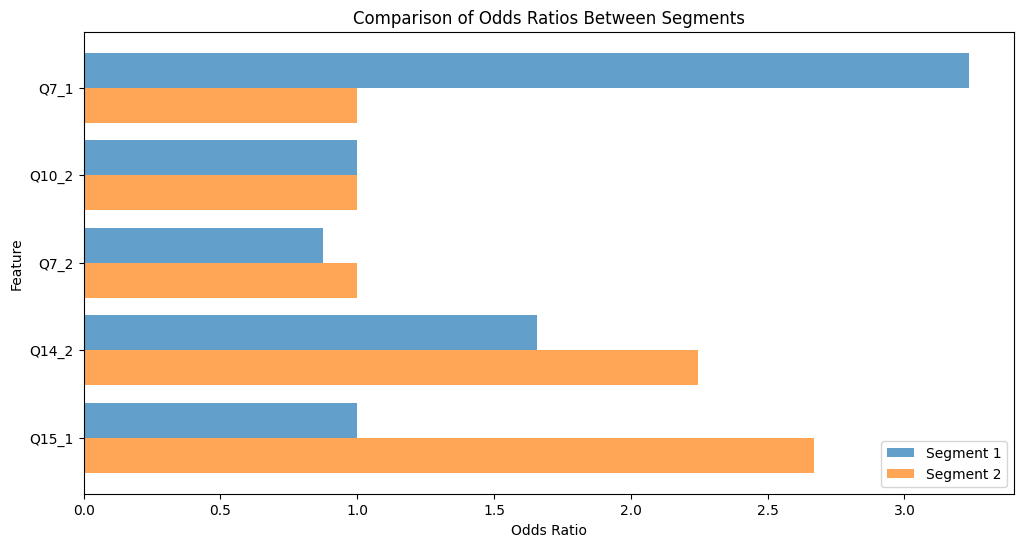

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Sort features by the difference in odds ratios for better visualization
coef_comparison = coef_comparison.sort_values(by="Odds Ratio Diff", ascending=False)

# Set figure size
plt.figure(figsize=(12, 6))

# Set bar width
bar_width = 0.4

# Set feature positions
indices = np.arange(len(coef_comparison))

# Plot bars for both segments
plt.barh(indices, coef_comparison["Odds Ratio Seg1"], bar_width, label="Segment 1", alpha=0.7)
plt.barh(indices + bar_width, coef_comparison["Odds Ratio Seg2"], bar_width, label="Segment 2", alpha=0.7)

# Feature labels
plt.yticks(indices + bar_width / 2, coef_comparison["Feature"])
plt.xlabel("Odds Ratio")
plt.ylabel("Feature")
plt.title("Comparison of Odds Ratios Between Segments")
plt.legend()

# Invert Y-axis for better readability
plt.gca().invert_yaxis()

# Show plot
plt.show()


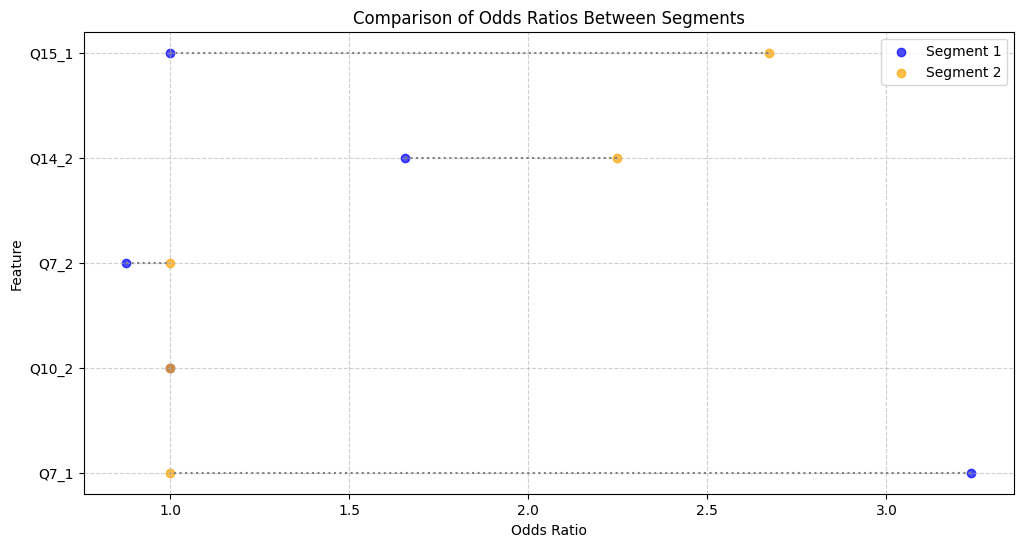

In [42]:
plt.figure(figsize=(12, 6))

# Scatter plot for each segment
plt.scatter(coef_comparison["Odds Ratio Seg1"], coef_comparison["Feature"], label="Segment 1", color="blue", alpha=0.7)
plt.scatter(coef_comparison["Odds Ratio Seg2"], coef_comparison["Feature"], label="Segment 2", color="orange", alpha=0.7)

# Draw lines connecting the points for better visualization
for i in range(len(coef_comparison)):
    plt.plot([coef_comparison["Odds Ratio Seg1"].iloc[i], coef_comparison["Odds Ratio Seg2"].iloc[i]], 
             [coef_comparison["Feature"].iloc[i], coef_comparison["Feature"].iloc[i]], 
             color='gray', linestyle='dotted')

plt.xlabel("Odds Ratio")
plt.ylabel("Feature")
plt.title("Comparison of Odds Ratios Between Segments")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()
